### Import librairies

In [9]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from imutils import face_utils 
import sys
import math

### Set the detector and predictor

In [10]:
DEBUG = False

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

### Landmarks points

In [11]:
# Avoir les points d'un visage
def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    if len(faces) == 0:
        #pas de visage
        return np.array([])
    
    shape = predictor(gray, faces[0])
    points = []
    for i in range(68):
        x = shape.part(i).x
        y = shape.part(i).y
        points.append((x, y))
    
    #Affiches les 68 landmarks du visage en rouge
    if DEBUG:
        for (i, rect) in enumerate(faces):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            for (x, y) in shape:
                cv2.circle(image, (x, y), 8, (0, 0, 255), -1)
    
    if DEBUG:
        for face in faces:
            x, y, w, h = (face.left(), face.top(), face.width(), face.height())
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return points

### Create the mask for the face

In [12]:
#Crée un masque pour les landmarks donnés
def create_face_mask(image, landmarks):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    hull = cv2.convexHull(landmarks)
    cv2.fillConvexPoly(mask, hull, 255)
    return mask

### Perspective pour les visages non-alignés

In [13]:
# La perpective quand les visages ne sont pas alignés
def warp_image(source, src_landmarks, dst_landmarks):
    h, _ = cv2.findHomography(src_landmarks, dst_landmarks)
    warped = cv2.warpPerspective(source, h, (source.shape[1], source.shape[0]))
    return warped

### Blend la destination, le masque et la source

In [14]:
def bilinear_interpolate(src, dest, mask, alpha):
    # pour pas modifier l'image de base
    temp = dest.copy()

    mask_indices = mask > 0 
    temp[mask_indices] = (1 - alpha) * dest[mask_indices] + alpha * src[mask_indices]

    return temp

### DEBUG : Triangle de delaunay

In [15]:
def draw_delaunay(image, landmarks):
    #maillage de Delaunay sur une image à partir des landmarks.
    
    delaunay = Delaunay(landmarks)

    for triangle_indices in delaunay.simplices:
        triangle_points = landmarks[triangle_indices]

        cv2.polylines(
            image, 
            [triangle_points],    
            isClosed=True,        
            color=(0, 255, 0),    
            thickness=5         
        )

    return image

### Main

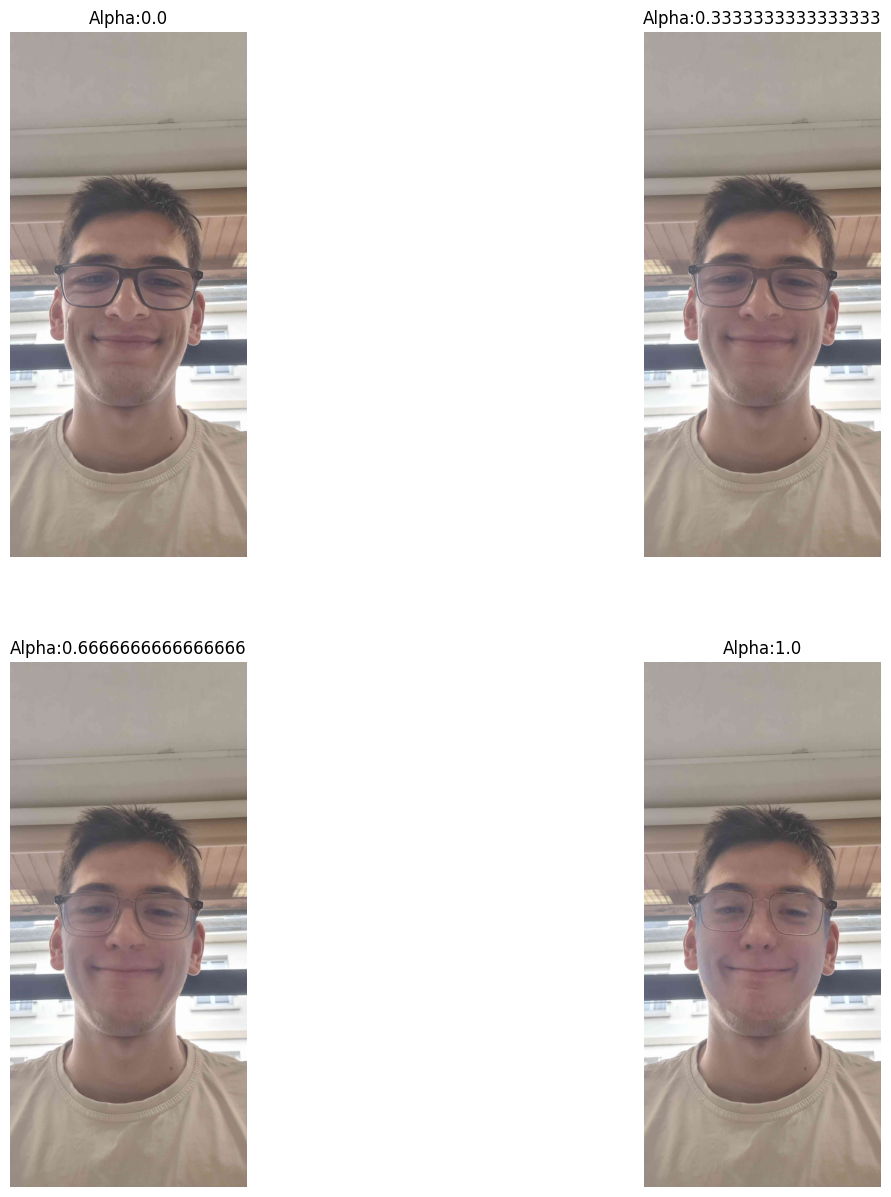

In [16]:
# Il ne faut pas prendre une image en portait et une en paysage, sinon le resize va tout casser et
# le model sera incapable de reperer un visage
source = cv2.imread("./image/ewen.jpg")
destination = cv2.imread("./image/savinien2.jpg")

source = cv2.resize(source, (destination.shape[1], destination.shape[0]))

src_landmarks = get_landmarks(source)
dst_landmarks = get_landmarks(destination)
src_landmarks = np.array(src_landmarks, dtype=np.int32)
dst_landmarks = np.array(dst_landmarks, dtype=np.int32)


if DEBUG:
    print(src_landmarks.size, dst_landmarks.size)
    
if(src_landmarks.size == 0 or dst_landmarks.size == 0):
    print("Pas de visage trouvé")
    sys.exit()
    
warped = warp_image(source, src_landmarks, dst_landmarks)
mask = create_face_mask(destination, dst_landmarks)
    
nb_image = 4
alpha_values = np.linspace(0, 1, nb_image)
#alpha_values = 0.5
blended_images = []

for alpha in alpha_values:
    blended = bilinear_interpolate(warped, destination, mask, alpha)
    blended_images.append(blended)
    if DEBUG:
        draw_delaunay(blended, dst_landmarks) 
 
if DEBUG:   
    draw_delaunay(destination, dst_landmarks)
    draw_delaunay(source, src_landmarks)

grid_size = (int(math.sqrt(nb_image)), int(math.sqrt(nb_image)))
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

for i, plot in enumerate(axes.flat):
    plot.imshow(cv2.cvtColor(blended_images[i], cv2.COLOR_BGR2RGB)) #merci cv2
    plot.set_title('Alpha:'+str(alpha_values[i]))
    plot.axis('off')

plt.show()

if DEBUG:
    h, w, c = (source.shape)
    nh = h/8
    nw = w/8
    sourceResize = cv2.resize(source, (int(nw), int(nh))) 
    
    h, w, c = (destination.shape)
    nh = h/8
    nw = w/8
    destinationResize = cv2.resize(destination, (int(nw), int(nh))) 

    while True:
        cv2.imshow("Blended", destinationResize)
        cv2.imshow("Blended2", sourceResize)
        k = cv2.waitKey(10) & 0xFF
        if k== 27:
            break
    cv2.destroyAllWindows()
